In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
feature_list = ['bant_submit', 'customer_country', 'business_unit','com_reg_ver_win_rate', 'customer_idx','customer_type', 'enterprise', 'historical_existing_cnt',	'id_strategic_ver',	'it_strategic_ver',	'idit_strategic_ver', 'customer_job', 'lead_desc_length', 'inquiry_type', 'product_category', 'product_subcategory',	'product_modelname', 'customer_country.1', 'customer_position', 'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',	'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area', 'business_subarea', 'lead_owner']

In [ ]:
!pip install missingno

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/LGAimers/Data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/LGAimers/Data/submission.csv')

In [ ]:
# 각 feature 내의 True vs False 비율 파이차트 그리기

def pie_value_ratios(df, column_name):
    if column_name == 'is_converted':
        # Calculate the ratio of values in the 'is_converted' column
        value_ratios = df[column_name].value_counts(normalize=True)

        # Print the ratios
        print(f"Ratios of values in {column_name}:")
        print(value_ratios * 100)  # Convert to percentages for display

    else:
        # Filter rows where the specified column is not null
        filtered_df = df[df[column_name].notnull()]

        # Calculate the ratio of values in the 'is_converted' column for the filtered rows
        value_ratios = filtered_df['is_converted'].value_counts(normalize=True)

        # Print the ratios for the filtered data
        print(f"Ratios of 'is_converted' values where {column_name} is not null:")
        print(value_ratios * 100)  # Convert to percentages for display

    # Define colors for the pie chart
    colors = ['#ea9999', '#7f7f7f']

    # Plot the ratios as a pie chart
    plt.figure(figsize=(8, 8))
    value_ratios.plot.pie(autopct='%.1f%%', startangle=90, colors=colors, textprops={'fontsize': 15})
    plt.title(f"Ratios of values in {column_name} (Train data)", fontsize=17)
    plt.ylabel('')  # Pie chart does not need a y-label

    plt.tight_layout()
    plt.show()


pie_value_ratios(df_train, 'is_converted')

In [ ]:
# 각 feature 내의 class 분포 막대그래프

def bar_value_ratios(df, column_name):
    # Calculate the ratio of values in the specified column
    value_ratios = df[column_name].value_counts(normalize=True) * 100  # Convert ratios to percentages

    # Print the ratios
    print(f"Ratios of values in {column_name}:")
    print(value_ratios)

    # Plot the ratios
    ax = value_ratios.plot(kind='bar')
    ax.set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
    ax.grid(False)  # 그리드 제거
    plt.title(f"Ratios of values in {column_name}")
    plt.xlabel('Value')
    plt.ylabel('Ratio (%)')

    # Annotate the bars with the ratio percentages
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.tight_layout()  # Adjust layout to make room for the annotations
    plt.show()

bar_value_ratios(df_train, 'bant_submit')

In [ ]:
#feature 내 class count 한번에 비교(true ratio X)
def plot_categorical_distribution(df, column_names):
    # 서브플롯의 개수는 column_names 리스트의 길이에 따라 달라집니다.
    fig, axes = plt.subplots(1, len(column_names), figsize=(14, 7), sharey=True)

    # 각 카테고리에 대한 카운트 플롯을 그립니다.
    for i, column in enumerate(column_names):
        sns.countplot(x=df[column], ax=axes[i], palette="Set2", edgecolor='black')
        axes[i].set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
        axes[i].grid(False)  # 그리드 제거
        axes[i].margins(0.12, 0.15)
        axes[i].xaxis.label.set_size(12)
        axes[i].xaxis.label.set_weight('bold')

    # 전체 그림의 제목을 추가합니다.
    plt.suptitle('Categorical Distribution',
                 fontsize=17,
                 fontweight='bold',
                 x=0.05, y=1.06,
                 ha='left')

    plt.tight_layout()
    plt.show()

# 함수 사용 예시
plot_categorical_distribution(df_train, ['enterprise', 'ver_cus', 'ver_pro'])

In [ ]:
# 각 (cateogory) featrue 내 class 분포

def pie_bar_cat_column(df_input, column_name, target):
    # Determine the number of unique values
    unique_values = df_input[column_name].nunique()

    # Adjust subplot arrangement based on the number of unique values
    if unique_values > 15:
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # Top-bottom layout for more than 15 unique values
        rotation_angle = 90
    else:
        fig, axes = plt.subplots(1, 2, figsize=(18, 5.5))  # Side-by-side layout for 15 or fewer unique values
        rotation_angle = 45

    # Sort the categories
    sorted_categories = df_input[column_name].value_counts().sort_index().index # 1번 해시태그

    # Plot the pie chart
    colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0', 'whitesmoke']
    df_input[column_name].value_counts().loc[sorted_categories].plot.pie(autopct='%1.1f%%', ax=axes[0] if unique_values <= 15 else axes[0], shadow=True, colors = colors)
    axes[0].set_ylabel('')  # Clear the y-axis label for the pie chart for neatness

    # Plot the count plot
    # Note: We ensure that the data is sorted according to the sorted categories for the count plot
    sorted_df = df_input.sort_values(by=column_name) # 2번 해시태그
    ax_countplot = sns.countplot(x=column_name, data=sorted_df, ax=axes[1] if unique_values <= 15 else axes[1], hue=target, order=sorted_categories, palette='pastel')

    # Rotate x-axis labels without triggering the warning
    for label in ax_countplot.get_xticklabels():
        label.set_rotation(rotation_angle)
        label.set_ha("right")
    axes[1].set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
    axes[1].grid(False)  # 그리드 제거
    axes[1].set_ylabel('Count')  # Add y-axis label for clarity
    axes[1].set_title(f'Distribution of {column_name} by {target}')  # Set title for each subplot for clarity

    plt.suptitle(f'{column_name} Analysis', fontsize=16)  # Adjust the main title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the suptitle and x-axis labels
    plt.show()

pie_bar_cat_column(df_train, 'business_unit', 'is_converted')

In [ ]:
# {data_count 기준 내림차순으로 상위 10개 시각화 + True_ratio}
# - 변수 내 class 10개 이상인 경우, class_count 갯수 내림차순으로 상위 10개만 뽑아 시각화
# - True ratio : 각 class내에 Ture/(False+Ture)

def bar_top_categories_with_ratio(df, column_name, top_n=10, target='is_converted'):
    # 상위 N개의 카테고리 선택
    top_categories = df[column_name].value_counts().head(top_n).index

    # 각 카테고리 별로 target의 True, False 개수 집계
    agg_df = df[df[column_name].isin(top_categories)].groupby([column_name, target]).size().unstack(fill_value=0)

    # True와 False의 합계를 기준으로 내림차순 정렬
    agg_df['total'] = agg_df.sum(axis=1)
    agg_df_sorted = agg_df.sort_values(by='total', ascending=False).drop('total', axis=1)

    # Stacked bar plot 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette("pastel")[0:2]  # 파스텔톤 색상 지정
    agg_df_sorted.plot(kind='barh', stacked=True, color=colors, ax=ax)

    plt.title(f'Top {top_n} {column_name} by Conversion Status - Descending Order')
    plt.xlabel('Count')
    plt.ylabel(column_name)
    plt.legend(title='Is Converted', labels=['False', 'True'], loc='lower right')
    ax.set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
    ax.grid(False)  # 그리드 제거
    plt.gca().invert_yaxis()  # y축의 순서를 뒤집어 내림차순으로 표시

    # True Ratio 값을 막대 위에 표시
    for index, (category, row) in enumerate(agg_df_sorted.iterrows()):
        total_count = row.sum()
        true_ratio = row[True] / total_count if total_count > 0 else 0
        # 막대의 오른쪽 끝에 True Ratio 텍스트 추가
        ax.text(row.sum(), index, f' True Ratio: {true_ratio:.2f}', va='center', ha='left')

    plt.show()


bar_top_categories_with_ratio(df_train, 'bant_submit', top_n=10, target='is_converted')

In [ ]:
# 각 feature 내 클래스의 False, True bar 따로 그림

def double_bar_cat_columns(df_input, categorical_vars, target):
    for column in categorical_vars:
        if column == target:
            continue

        # Determine the number of unique values
        unique_values = df_input[column].nunique()

        # Create figure for the count plot
        plt.figure(figsize=(18, 5.5))  # Size for a single count plot

        # Sort the categories
        sorted_categories = df_input[column].value_counts().sort_index().index

        # Plot the count plot with pastel palette
        ax_countplot = sns.countplot(x=column, data=df_input, hue=target, order=sorted_categories, palette='pastel')
        ax_countplot.grid(False)  # Disable the grid
        ax_countplot.set_facecolor('white')  # Set background to white

        # Set x-axis labels to be horizontal
        ax_countplot.set_xticklabels(ax_countplot.get_xticklabels(), rotation=0, ha="center")

        plt.ylabel('Count')  # Add y-axis label for clarity
        plt.title(f'Distribution of {column} by {target}')  # Set title for clarity

        plt.suptitle(f'{column} Analysis', fontsize=16)  # Adjust the main title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
        plt.show()

double_bar_cat_columns(df_train, ['bant_submit'], target='is_converted')

In [ ]:
# 클래스별 is_converted 비율만 보기
def bar_true_ratio(df_input, column_name):
    class_conversion_ratio = df_input.groupby(column_name)['is_converted'].mean().reset_index()

    class_conversion_ratio_sorted = class_conversion_ratio.sort_values(by='is_converted', ascending=False)

    plt.figure(figsize=(12, 8))
    # x,y 값 & label 바꾸면 됌
    sns.barplot(x='is_converted', y=column_name, data=class_conversion_ratio_sorted, palette='pastel')
    plt.xlabel('Is Converted Ratio')
    plt.ylabel('Response Corporate')
    plt.title('Is Converted Ratio by Response Corporate (Sorted by Size)')

    # 현재의 Axes 객체를 가져와서 그리드를 제거
    ax = plt.gca()
    ax.grid(False)  # 그리드 비활성화

    # 배경색을 하얀색으로 설정
    ax.set_facecolor('white')

    plt.show()

bar_true_ratio(df_train, 'response_corporate')

In [ ]:
# 각 feature 내 class의 true ratio

def show_binary_ratio(df_input, column_name: str, target: str):
    print(f'{column_name}: {df_input[column_name].notnull().sum()}')

    # Get unique values in the column
    unique_values = sorted(df_input[column_name].dropna().unique())

    longest_str = max(len(f"    {value}" ) for value in unique_values)
    for value in unique_values:
        # For each unique value, count occurrences of target 0 and 1
        count_0 = df_input[(df_input[column_name] == value) & (df_input[target] == False)].shape[0]
        count_1 = df_input[(df_input[column_name] == value) & (df_input[target] == True)].shape[0]
        count_01 = count_0 + count_1

        # Print counts for target 0 and 1 with indentation
        #print(f"{column}".ljust(longest_str)
        print(f'    {value}'.ljust(longest_str), end=' ')
        print(f'True Ratio: {count_1 / count_01:.2f}, Total Count: {count_01}')

    # Print a blank line for better readability between columns
    print()

show_binary_ratio(df_train,  'business_subarea', target='is_converted')

In [ ]:
# 결측치 시각화
msno.matrix(df_train)

# 특정 컬럼 기준 정렬된 결측치 시각화
# sorted_bus_area = df_train.sort_values('business_area')
# msno.matrix(sorted_bus_area)

In [ ]:
def show_missing_rates(df_input, selected_columns=None):
    # Calculate the total number of rows in the DataFrame
    total_rows = len(df_input)

    if selected_columns is None:
        selected_columns = df_input.columns

    # Find the longest column name for formatting
    # Determine the longest string needed for formatting the column name and its data type
    longest_str = max(len(f"{column}" ) for column in selected_columns)
    #longest_column_name = max(len(column) for column in selected_columns)

    # Iterate over each column in the DataFrame
    for column in selected_columns:
        # Count the number of missing values in the column
        missing_count = df_input[column].isna().sum()

        # Calculate the percentage of missing values
        missing_rate = (missing_count / total_rows) * 100

        # Get the data type of the column
        data_type = df_input[column].dtype

        # Print the column name, its data type, and its missing rate with aligned formatting
        print(f"{column}".ljust(longest_str) + f": {missing_rate:5.2f}% missing values ({data_type})" )


show_missing_rates(df_train)

In [ ]:
def plot_missing(df_input):
    sns.displot(data=df_input.isnull().melt(value_name='missing'),
        y='variable',
        hue='missing',
        multiple='fill',
        height=8,
    #     width=10,
        aspect=1.6,
        palette='pastel'
    )

    # specifying a threshold value
    plt.axvline(0.4, color='r')
    plt.title('Null Values in Train Data', fontsize=13)
    plt.show()

plot_missing(df_train)

In [ ]:
# 두 feature 간 class 연관성 비교 → 일대일 대응인지 다대일 대응인지 관계 알 수 있음

def compare_features_class(df_input, cloumn_names:list):
    # Drop rows where any of the two columns is NaN
    df_cleaned = df_input.dropna(subset=cloumn_names)

    # Create a pivot table with counts of each combination
    pivot_table = df_cleaned.pivot_table(index=cloumn_names[0], columns=cloumn_names[1], aggfunc=len, fill_value=0)

    # Plot heatmap
    plt.figure(figsize=(45, 15))
    sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt="d")
    plt.title(f'Heatmap of{cloumn_names[0]} vs. {cloumn_names[1]}')
    plt.ylabel(cloumn_names[0])
    plt.xlabel(cloumn_names[1])
    plt.xticks(rotation=90)
    plt.show()

compare_features_class(df_train, ['business_area', 'business_subarea'])

In [ ]:
# 특정 feature 내 True 분포를 산점도로 나타내기

def scatter_column_ratio(df_input, colume_name:str):
    class_conversion_ratio = df_input.groupby(colume_name)['is_converted'].mean().reset_index()
    temp = df_input[colume_name].value_counts()
    merged_df = pd.merge(class_conversion_ratio, temp, on=colume_name)

    print(merged_df.head())

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=merged_df, x='count', y='is_converted', color='blue', alpha=0.5)

    plt.xlim(0, 1000)
    plt.xlabel('cnt')
    plt.ylabel('is_converted')
    plt.title('Scatter Plot of cnt vs. is_converted')
    plt.grid(True)
    plt.show()

scatter_column_ratio(df_train, 'lead_owner')

In [ ]:
# train, test 존재하는 데이터 분포 알기
def plot_pie_chart(train, test, feat_names):
    fig, axs = plt.subplots(len(feat_names), 1, figsize=(16, 64))
    axs = axs.flatten()

    for i, feat_name in enumerate(feat_names):
        train_set = set(train[feat_name])
        test_set = set(test[feat_name])

        both_set = train_set & test_set
        only_train = train_set - both_set
        only_test = test_set - both_set

        num_train, num_test, num_both = 0, 0, 0
        for cls in only_train:
            num_train += len(train[train[feat_name] == cls])

        for cls in only_test:
            num_test += len(test[test[feat_name] == cls])

        for cls in both_set:
            num_both += len(train[train[feat_name] == cls]) + len(test[test[feat_name] == cls])

        # 각 집합의 크기 계산
        sizes = [num_train, num_both, num_test]
        labels = ['Only Train', 'Both', 'Only Test']
        colors = ['lightcoral', 'lightskyblue', 'lightgreen']

        # 파이 차트 그리기
        axs[i].set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
        axs[i].grid(False)  # 그리드 제거
        axs[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[i].axis('equal')
        axs[i].set_title(f'{feat_name}')

    plt.tight_layout()
    plt.show()
plot_pie_chart(df_train, df_test, ['customer_idx', 'business_unit'])

In [ ]:
# class별 value_counts로 그리기
def plot_pie_chart_fillna(train, test, feat_names):
    fig, axs = plt.subplots(len(feat_names), 1, figsize=(16, 64))
    axs = axs.flatten()

    for i, feat_name in enumerate(feat_names):
        train_set = set(train[feat_name])
        test_set = set(test[feat_name])

        both_set = train_set & test_set
        only_train = train_set - both_set
        only_test = test_set - both_set

        num_train, num_test, num_both, num_na = 0, 0, 0, 0
        num_na = train[feat_name].isna().sum() + test[feat_name].isna().sum()
        for cls in only_train:
            num_train += len(train[train[feat_name] == cls])

        for cls in only_test:
            num_test += len(test[test[feat_name] == cls])

        for cls in both_set:
            num_both += len(train[train[feat_name] == cls]) + len(test[test[feat_name] == cls])

        # 각 집합의 크기 계산
        sizes = [num_train, num_both, num_test, num_na]
        labels = ['Only Train', 'Both', 'Only Test', 'UNK']
        colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'lightgray']

        # 파이 차트 그리기
        axs[i].set_facecolor('white')  # 축의 배경색을 하얀색으로 설정
        axs[i].grid(False)  # 그리드 제거
        axs[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        axs[i].axis('equal')
        axs[i].set_title(f'{feat_name}')

    plt.tight_layout()
    plt.show()

plot_pie_chart_fillna(df_train, df_test, ['customer_idx', 'business_unit'])

In [ ]:
#featrue describe boxplot
def describe_boxplot(df_input,column_name):
    print(df_input[column_name].describe())
    plt.figure(figsize = (2, 5))
    sns.boxplot(y = column_name, data = df_input)
    plt.show()

describe_boxplot(df_train,'ver_win_ratio_per_bu')

In [ ]:
# feature 내 상위 50개 클래스 분포 막대그래프 & 워드 클라우드 시각화
def wordcloud_visualize(df):

    # 토큰과 빈도수를 따로 분리합니다.
    tokens = list(df.value_counts().keys())
    frequencies = df.value_counts()

    # 상위 n개의 토큰만 선택하여 시각화할 수도 있습니다.
    n = 50
    top_tokens = tokens[:n]
    top_frequencies = frequencies[:n]

    # 막대 그래프로 시각화합니다.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(top_tokens)), top_frequencies, tick_label=top_tokens)
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title('Top {} Tokens Frequency'.format(n))
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 워드 클라우드로 시각화합니다.
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Tokens')
    plt.show()

wordcloud_visualize(df_train['customer_country'])

In [ ]:
# 비슷한 값 처리
# df_copy = df_train.copy()
# df_copy.loc[df_copy['customer_job'] == 'others', 'customer_job'] = 'other'

# feature 내 n 이상 , m 미만의 개수 이상 나오는 것들만 필터링

def threshold_counts(df_input, column_name,n,m):
    nunique = []
    threshold_list = []

    # 값의 개수를 세고, 일정 개수 이상 나오는 것들만 필터링
    for threshold in range(n, m):
        threshold = threshold
        value_counts = df_input[column_name].value_counts()
        filtered_values = value_counts[value_counts >= threshold].index

        # 필터링된 값들로 DataFrame 필터링
        filtered_df = df_input[df_input[column_name].isin(filtered_values)]

        threshold_list.append(threshold)
        nunique.append(filtered_df[column_name].nunique())
    # 그래프 그리기
    plt.plot(threshold_list, nunique)

    # 그래프 제목과 축 라벨 설정
    plt.title('Num of unique value with threshold filtering')
    plt.xlabel('Threshold')
    plt.ylabel('Num of unique value')

    # 그래프 보여주기
    plt.show()

threshold_counts(df_train, 'customer_job',1,50)

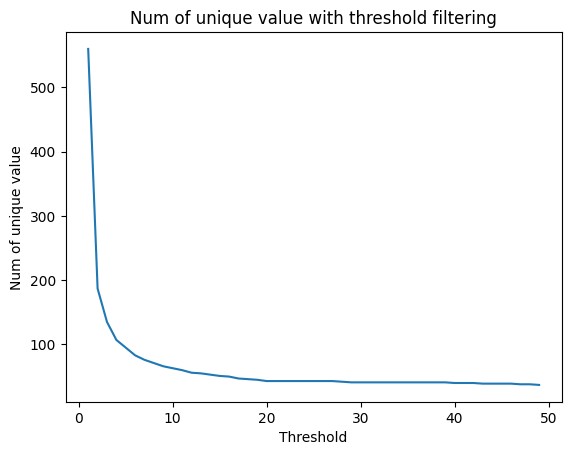

In [38]:
# 비슷한 값 처리
# df_copy = df_train.copy()
# df_copy.loc[df_copy['customer_job'] == 'others', 'customer_job'] = 'other'

# feature 내 n 이상 , m 미만의 개수 이상 나오는 것들만 필터링

def threshold_counts(df_input, column_name,n,m):
    nunique = []
    threshold_list = []

    # 값의 개수를 세고, 일정 개수 이상 나오는 것들만 필터링
    for threshold in range(n, m):
        threshold = threshold
        value_counts = df_input[column_name].value_counts()
        filtered_values = value_counts[value_counts >= threshold].index

        # 필터링된 값들로 DataFrame 필터링
        filtered_df = df_input[df_input[column_name].isin(filtered_values)]

        threshold_list.append(threshold)
        nunique.append(filtered_df[column_name].nunique())
    # 그래프 그리기
    plt.plot(threshold_list, nunique)

    # 그래프 제목과 축 라벨 설정
    plt.title('Num of unique value with threshold filtering')
    plt.xlabel('Threshold')
    plt.ylabel('Num of unique value')

    # 그래프 보여주기
    plt.show()

threshold_counts(df_train, 'customer_job',1,50)